# Tech Challenge – FIAP (Fase 4)  
## LSTM para prever **fechamento** da ação do Itaú (**ITUB4.SA**) usando `yfinance`

- Coleta de dados com **yfinance**
- Feature engineering (médias móveis, retornos, volatilidade, RSI)
- Preparação de janelas (lookback) para LSTM
- Split temporal: treino / validação / teste (sem *shuffle*)
- Métricas: **MAE, RMSE, MAPE**
- Salvamento do modelo e do scaler (para deploy em API)



In [ ]:
# Instalar dependências no seu ambiente:
# !pip install yfinance tensorflow scikit-learn pandas numpy matplotlib


In [82]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras


In [105]:
from src.data_loader import fetch_yahoo_prices

df = fetch_yahoo_prices(
    "ITUB4.SA",
    start="2021-01-01",
    interval="1d"
)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-05 13:00:00,24.986759,25.110327,24.616062,24.783758,18.057083,44519988
2021-02-08 13:00:00,24.713150,24.889673,24.280670,24.324800,17.722704,32786187
2021-02-09 13:00:00,24.263018,25.075022,24.033539,24.616062,17.934912,42778341
2021-02-10 13:00:00,24.624889,24.880848,24.165932,24.439541,17.806299,32474159
2021-02-11 13:00:00,24.704325,24.827890,24.271845,24.439541,17.806299,25381012


In [106]:
'''# 1) Coleta de dados (yfinance)
TICKER = "ITUB4.SA"
START = "2024-01-01"
END = None         # None = até hoje
INTERVAL = "1d"    # diário

df = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)
if df is None or df.empty:
    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")
df = df.dropna()
df.head()
'''

'# 1) Coleta de dados (yfinance)\nTICKER = "ITUB4.SA"\nSTART = "2024-01-01"\nEND = None         # None = até hoje\nINTERVAL = "1d"    # diário\n\ndf = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=False, progress=False)\nif df is None or df.empty:\n    raise ValueError(f"Nenhum dado retornado para {TICKER}. Verifique ticker/período.")\ndf = df.dropna()\ndf.head()\n'

In [132]:
# 2) Feature engineering (inspirado no seu código original, adaptado para ações)

def rsi_wilder(close: pd.Series, period: int = 14) -> pd.Series:
    """
    Calcula o RSI (Relative Strength Index) utilizando o método original de
    Wilder, baseado em médias móveis exponenciais suavizadas.

    Parâmetros
    ----------
    close : pd.Series
        Série temporal com os preços de fechamento.
    period : int, opcional
        Período do RSI (padrão = 14), conforme definição clássica.

    Retorno
    -------
    pd.Series
        Série com os valores do RSI no intervalo [0, 100].
    """

    # Diferença entre preços consecutivos (variação diária)
    delta = close.diff()

    # Ganhos: mantém apenas variações positivas, perdas viram 0
    gain = delta.clip(lower=0)

    # Perdas: inverte o sinal e mantém apenas variações negativas (em módulo)
    loss = (-delta).clip(lower=0)

    # Suavização de Wilder:
    # utiliza média móvel exponencial com fator alpha = 1 / period
    # isso replica o método original do RSI clássico
    avg_gain = gain.ewm(alpha=1 / period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, adjust=False).mean()

    # Relative Strength (RS):
    # razão entre ganho médio e perda média
    # adiciona-se um pequeno valor para evitar divisão por zero
    rs = avg_gain / (avg_loss + 1e-12)

    # Fórmula final do RSI
    # RSI = 100 - (100 / (1 + RS))
    return 100 - (100 / (1 + rs))


# Cria um DataFrame de features a partir do DataFrame original (mantém df intacto)
feat = df.copy()

# Médias móveis simples (SMA) do preço ajustado:
# - 21 pregões ~ “1 mês” de mercado (aprox.)
# - 9 pregões ~ curto prazo
feat["avg_last_21"] = feat["Adj Close"].rolling(window=21).mean()
feat["avg_last_9"]  = feat["Adj Close"].rolling(window=9).mean()

# Retorno simples diário em %: (preço_hoje / preço_ontem - 1) * 100
# Isso transforma preço em variação relativa, útil para medir momentum/volatilidade
feat["simple_returns"] = feat["Adj Close"].pct_change() * 100.0

# Volatilidade (desvio padrão) dos retornos em janelas diferentes:
# - 20 dias ~ volatilidade mensal (aprox.)
# - 5 dias  ~ volatilidade semanal (aprox.)
feat["std_last_20_returns"] = feat["simple_returns"].rolling(window=20).std()
feat["std_last_5_returns"]  = feat["simple_returns"].rolling(window=5).std()

# Volatilidade do volume em 5 dias:
# mede variações recentes de liquidez/atividade de negociação
feat["std_last_5_volume"]   = feat["Volume"].rolling(window=5).std()

# RSI (Relative Strength Index) pelo método clássico de Wilder (period=14)
# captura momentum e possíveis condições de sobrecompra/sobrevenda
feat["rsi"] = rsi_wilder(feat["Adj Close"], period=14)

# Target do Tech Challenge:
# prever o preço de fechamento do PRÓXIMO dia (t+1)
# shift(-1) move a série para "cima", alinhando features do dia t com o close do dia t+1
feat["y_next_close"] = feat["Adj Close"].shift(-1)

# Remove linhas com NaN geradas por:
# - rolling (primeiros dias não têm janela completa)
# - pct_change (primeira linha vira NaN)
# - shift(-1) (última linha vira NaN)
feat = feat.dropna().copy()

# Visualiza as últimas linhas para validar features e target
feat.tail()



,Open,High,Low,Close,Adj Close,Volume,avg_last_21,avg_last_9,simple_returns,std_last_20_returns,std_last_5_returns,std_last_5_volume,rsi,y_next_close
Date,,,,,,,,,,,,,,
2026-01-29 13:00:00,46.680000,47.049999,45.650002,46.150002,46.131561,36252700,41.159823,43.288251,-0.410009,1.534916,1.186987,6.257018e+06,83.153822,45.481819
2026-01-30 13:00:00,46.090000,46.380001,44.980000,45.500000,45.481819,38117000,41.459141,43.949098,-1.408455,1.601278,1.740438,5.772501e+06,76.380254,45.880001
2026-02-02 13:00:00,45.790001,46.099998,45.430000,45.880001,45.880001,28095400,41.780362,44.613093,0.875475,1.593364,1.722924,4.617690e+06,77.585273,46.139999
2026-02-03 13:00:00,46.299999,46.980000,45.889999,46.139999,46.139999,48570600,42.086832,45.111610,0.566692,1.593551,1.378611,7.319312e+06,78.361553,44.619999
2026-02-04 13:00:00,45.900002,45.980000,44.049999,44.619999,44.619999,48683500,42.309497,45.284634,-3.294323,1.760426,1.687996,8.777101e+06,64.333959,45.700001


In [144]:
# 3) Definição de X e y (regressão)
FEATURE_COLS = [
    "Adj Close",
    "Volume",
    "simple_returns",
    "std_last_5_returns",
    "std_last_20_returns",
    "avg_last_9",
    "avg_last_21",
    "rsi"
]


X = feat[FEATURE_COLS].values.astype("float32")
y = feat[["y_next_close"]].values.astype("float32")  # (N,1)

len(X), X.shape, y.shape


(1227, (1227, 8), (1227, 1))

In [134]:
# 4) Split temporal + normalização (ajuste feito APENAS no conjunto de treino)

def temporal_split(X, y, train_ratio=0.70, val_ratio=0.15):
    """
    Realiza a divisão temporal dos dados em treino, validação e teste,
    preservando a ordem cronológica da série temporal.

    Parâmetros
    ----------
    X : array-like
        Matriz de features ordenadas no tempo (do passado para o futuro).
    y : array-like
        Vetor de targets correspondentes às features.
    train_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de treino.
    val_ratio : float, opcional
        Proporção dos dados destinada ao conjunto de validação.

    Retorno
    -------
    (X_train, y_train), (X_val, y_val), (X_test, y_test)
        Tuplas contendo os conjuntos de treino, validação e teste.
    """

    # Número total de amostras
    n = len(X)

    # Tamanho do conjunto de treino
    n_train = int(n * train_ratio)

    # Tamanho do conjunto de validação
    n_val = int(n * val_ratio)

    # Conjunto de treino: dados mais antigos
    X_train, y_train = X[:n_train], y[:n_train]

    # Conjunto de validação: dados imediatamente após o treino
    X_val, y_val = X[n_train:n_train + n_val], y[n_train:n_train + n_val]

    # Conjunto de teste: dados mais recentes (nunca vistos pelo modelo)
    X_test, y_test = X[n_train + n_val:], y[n_train + n_val:]

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Aplica o split temporal aos dados
(X_train, y_train), (X_val, y_val), (X_test, y_test) = temporal_split(X, y)

# Inicializa os normalizadores Min-Max para features (X) e target (y)
# Cada scaler será ajustado SOMENTE com os dados de treino
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

# Normalização das features:
# - fit_transform apenas no treino (evita vazamento de informação)
# - transform nos conjuntos de validação e teste
X_train_s = x_scaler.fit_transform(X_train)
X_val_s   = x_scaler.transform(X_val)
X_test_s  = x_scaler.transform(X_test)

# Normalização do target:
# - fit_transform apenas no treino
# - transform nos demais conjuntos
y_train_s = y_scaler.fit_transform(y_train)
y_val_s   = y_scaler.transform(y_val)
y_test_s  = y_scaler.transform(y_test)

# Exibe as dimensões dos dados normalizados de treino
X_train_s.shape, y_train_s.shape


((858, 8), (858, 1))

In [135]:
print("y_train raw min/max:", float(y_train.min()), float(y_train.max()))
print("y_train_s min/max:", float(y_train_s.min()), float(y_train_s.max()))
print("y_scaler min/max:", y_scaler.data_min_, y_scaler.data_max_)


y_train raw min/max: 13.914319038391113 27.79253578186035
y_train_s min/max: 0.0 1.0
y_scaler min/max: [13.914319] [27.792536]


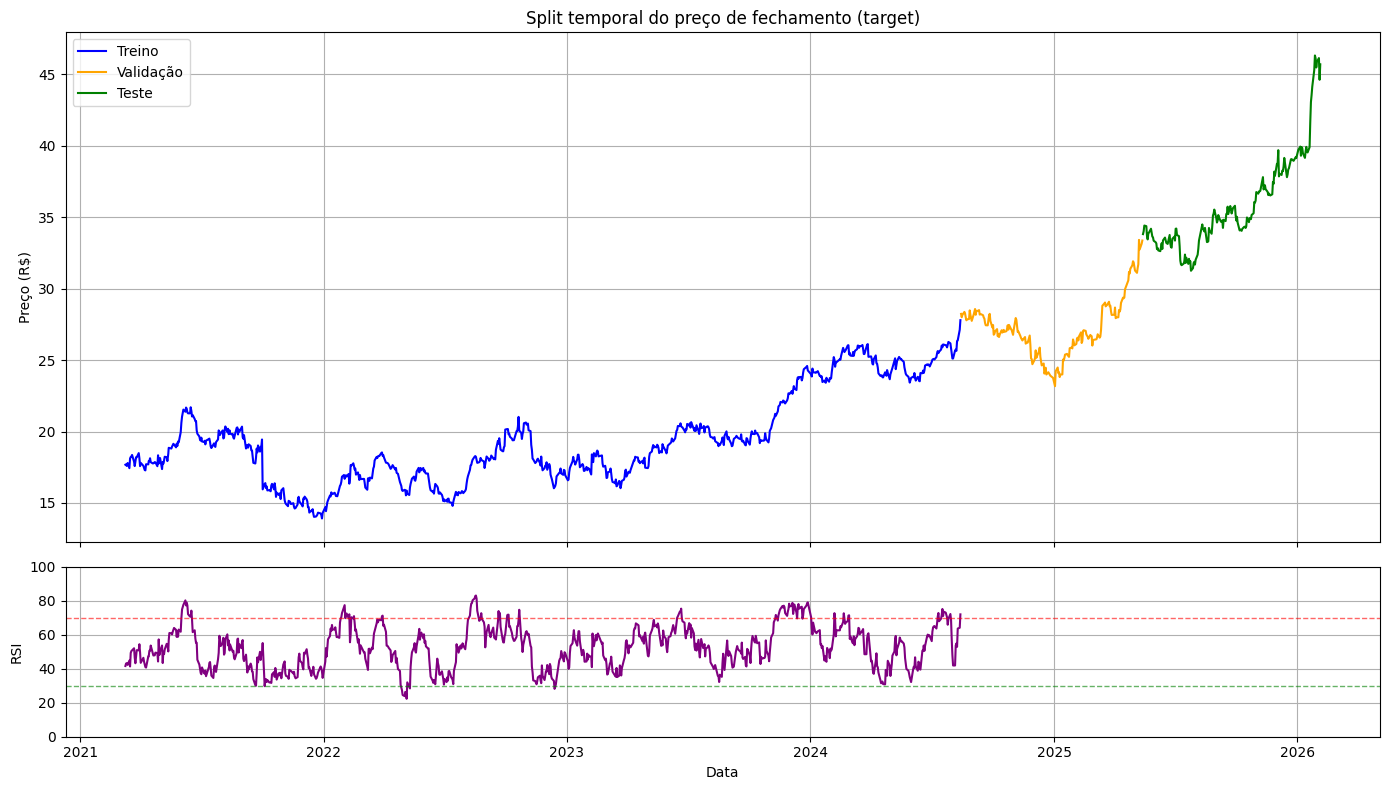

In [136]:
# Séries RAW (apenas para visualização)
y_series_raw = feat["y_next_close"].copy()
rsi_series   = feat["rsi"].copy()

# Split temporal preservando o índice (somente para PLOT)
n = len(y_series_raw)
n_train = int(n * 0.70)
n_val = int(n * 0.15)

y_train_raw = y_series_raw.iloc[:n_train]
y_val_raw   = y_series_raw.iloc[n_train:n_train+n_val]
y_test_raw  = y_series_raw.iloc[n_train+n_val:]

rsi_train = rsi_series.iloc[:n_train]
rsi_val   = rsi_series.iloc[n_train:n_train+n_val]
rsi_test  = rsi_series.iloc[n_train+n_val:]

# Figura com dois subplots
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14, 8), sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# =========================
# Gráfico 1: Preço (RAW)
# =========================
ax1.plot(y_train_raw.index, y_train_raw.values, label="Treino", color="blue")
ax1.plot(y_val_raw.index, y_val_raw.values, label="Validação", color="orange")
ax1.plot(y_test_raw.index, y_test_raw.values, label="Teste", color="green")

ax1.set_title("Split temporal do preço de fechamento (target)")
ax1.set_ylabel("Preço (R$)")
ax1.legend()
ax1.grid(True)

# =========================
# Gráfico 2: RSI
# =========================
ax2.plot(rsi_train.index, rsi_train.values, color="purple")

ax2.axhline(70, linestyle="--", linewidth=1, color="red", alpha=0.6)
ax2.axhline(30, linestyle="--", linewidth=1, color="green", alpha=0.6)

ax2.set_ylabel("RSI")
ax2.set_xlabel("Data")
ax2.set_ylim(0, 100)
ax2.grid(True)

plt.tight_layout()
plt.show()


In [137]:
# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int, name: str = ""):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Espera receber X_scaled e y_scaled já NORMALIZADOS (ex.: MinMaxScaler).
    """

    # Converte para numpy
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante y em formato (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    # Valida shapes
    if X_scaled.ndim != 2:
        raise ValueError(f"{name}X_scaled deve ser 2D (n_amostras, n_features). Shape: {X_scaled.shape}")
    if y_scaled.ndim != 2 or y_scaled.shape[1] != 1:
        raise ValueError(f"{name}y_scaled deve ser 2D (n_amostras, 1). Shape: {y_scaled.shape}")
    if len(X_scaled) != len(y_scaled):
        raise ValueError(f"{name}X e y devem ter o mesmo tamanho. X={len(X_scaled)} y={len(y_scaled)}")

    # Aviso útil: se y_scaled estiver em escala "de preço" (ex.: 16–46), algo está errado
    # (em MinMaxScaler, normalmente fica em ~0–1, podendo exceder 1 no teste)
    if y_scaled.max() > 5 or y_scaled.min() < -1:
        raise ValueError(
            f"{name}y_scaled parece NÃO normalizado (min={y_scaled.min():.3f}, max={y_scaled.max():.3f}). "
            "Você provavelmente passou y_test em vez de y_test_s."
        )

    Xw, yw = [], []

    # Cria janelas
    for i in range(lookback, len(X_scaled)):
        Xw.append(X_scaled[i - lookback:i, :])  # (lookback, n_features)
        yw.append(y_scaled[i, 0])               # escalar

    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste (IMPORTANTE: sempre usar *_s)
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK, name="train_")
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK, name="val_")
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK, name="test_")

# Verifica shapes finais
print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Xva:", Xva.shape, "yva:", yva.shape)
print("Xte:", Xte.shape, "yte:", yte.shape)

# Verifica ranges (devem estar próximos de 0-1; teste pode exceder 1)
print("ytr min/max:", float(ytr.min()), float(ytr.max()))
print("yte min/max:", float(yte.min()), float(yte.max()))


Xtr: (848, 10, 8) ytr: (848, 1)
Xva: (174, 10, 8) yva: (174, 1)
Xte: (175, 10, 8) yte: (175, 1)
ytr min/max: 0.0 1.0
yte min/max: 1.2493057250976562 2.3351101875305176


In [138]:
# 5) Criação de janelas (lookback) para LSTM
def make_windows(X_scaled, y_scaled, lookback: int):
    """
    Cria janelas temporais (sliding windows) para treinamento de modelos LSTM.

    Parâmetros
    ----------
    X_scaled : array-like (numpy array ou pandas DataFrame)
        Features já normalizadas, no formato (n_amostras, n_features).
    y_scaled : array-like (numpy array ou pandas Series/DataFrame)
        Target já normalizado, no formato (n_amostras,) ou (n_amostras, 1).
    lookback : int
        Número de passos temporais anteriores utilizados como entrada.

    Retorno
    -------
    Xw : np.ndarray
        Array 3D no formato (n_janelas, lookback, n_features),
        compatível com entrada de LSTM.
    yw : np.ndarray
        Array 2D no formato (n_janelas, 1), correspondente ao target futuro.
    """

    # Garante que X e y sejam numpy arrays
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    y_scaled = np.asarray(y_scaled, dtype=np.float32)

    # Garante que y tenha shape (n, 1)
    if y_scaled.ndim == 1:
        y_scaled = y_scaled.reshape(-1, 1)

    Xw, yw = [], []

    # Criação das janelas temporais
    for i in range(lookback, len(X_scaled)):
        # Janela de entrada: dados do tempo (i-lookback) até (i-1)
        Xw.append(X_scaled[i - lookback:i, :])

        # Target associado: valor do tempo i
        yw.append(y_scaled[i, 0])

    # Converte listas em arrays numpy
    Xw = np.array(Xw, dtype=np.float32)
    yw = np.array(yw, dtype=np.float32).reshape(-1, 1)

    return Xw, yw


# Tamanho da janela temporal (lookback)
LOOKBACK = 10

# Criação das janelas para treino, validação e teste
Xtr, ytr = make_windows(X_train_s, y_train_s, LOOKBACK)
Xva, yva = make_windows(X_val_s,   y_val_s,   LOOKBACK)
Xte, yte = make_windows(X_test_s,  y_test_s,  LOOKBACK)

# Verifica shapes finais
Xtr.shape, ytr.shape, Xte.shape


((848, 10, 8), (848, 1), (175, 10, 8))

In [139]:
# 6) Modelo LSTM (regressão para previsão de preço)

# Número de features de entrada (ex.: médias móveis, RSI, volatilidade, etc.)
# Corresponde à terceira dimensão do tensor Xtr: (amostras, lookback, features)
n_features = Xtr.shape[2]

# Define um modelo sequencial de redes neurais recorrentes (LSTM)
model = keras.Sequential([
    # Camada de entrada:
    # recebe sequências temporais com comprimento LOOKBACK
    # e n_features variáveis em cada passo de tempo
    keras.layers.Input(shape=(LOOKBACK, n_features)),

    # Primeira camada LSTM com 64 unidades
    # return_sequences=True permite que a saída seja uma sequência,
    # necessária para empilhar outra camada LSTM em seguida
    keras.layers.LSTM(64, return_sequences=True),

    # Dropout para reduzir overfitting
    # desativa aleatoriamente 20% das unidades durante o treino
    keras.layers.Dropout(0.1),

    # Segunda camada LSTM com 32 unidades
    # return_sequences=False (padrão), retornando apenas o último estado,
    # que resume a informação temporal da sequência inteira
    keras.layers.LSTM(32),

    # Dropout adicional para regularização
    keras.layers.Dropout(0.1),

    # Camada densa final com 1 neurônio:
    # saída contínua correspondente ao preço de fechamento previsto (regressão)
    keras.layers.Dense(1)
])

# Compila o modelo:
# - Otimizador Adam com taxa de aprendizado 0.001
# - Função de perda MSE (Mean Squared Error), adequada para regressão
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-3),
    loss="mse"
)

# Exibe um resumo da arquitetura do modelo
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 10, 64)              │          18,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0314 - val_loss: 0.0196 - learning_rate: 0.0020
Epoch 2/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0053 - val_loss: 0.0202 - learning_rate: 0.0020
Epoch 3/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0104 - learning_rate: 0.0020
Epoch 4/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0037 - val_loss: 0.0080 - learning_rate: 0.0020
Epoch 5/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0035 - val_loss: 0.0061 - learning_rate: 0.0020
Epoch 6/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0038 - val_loss: 0.0077 - learning_rate: 0.0020
Epoch 7/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0036 - val_loss: 0.0088 - learning_rate: 0.0020
Epoch 8/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0057 - learning_rate: 0.0020
Epoch 9/80
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0043 - learning_rate: 0.0020
Epoch 10/80
27/27 ━

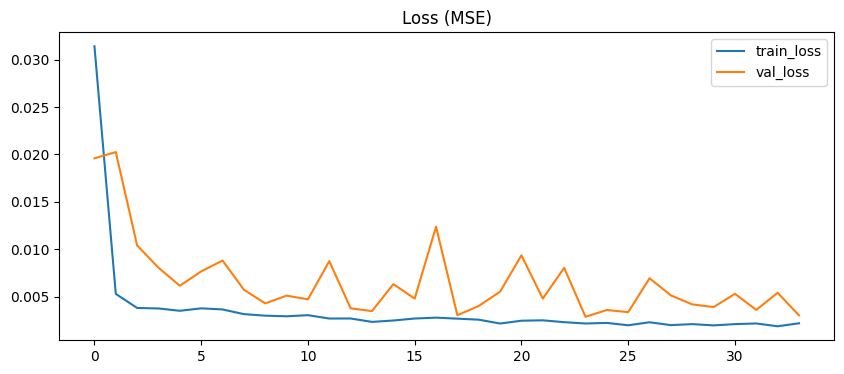

In [140]:
# 7) Treinamento
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5),
]

history = model.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=80,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss (MSE)")
plt.show()


In [141]:
# Predict in scaled space
y_pred_s = model.predict(Xte, verbose=0).astype("float32")

# Inverse transform BOTH arrays back to BRL
y_true = y_scaler.inverse_transform(yte)
y_pred = y_scaler.inverse_transform(y_pred_s)

# Metrics (BRL)
'''mae  = np.mean(np.abs(y_true - y_pred))
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100'''

def mae(y_true, y_pred):
    """
    Mean Absolute Error (MAE)
    Mede o erro médio absoluto entre valores reais e previstos.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean(np.abs(y_true - y_pred))


def rmse(y_true, y_pred):
    """
    Root Mean Squared Error (RMSE)
    Penaliza erros maiores de forma mais agressiva.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def mape(y_true, y_pred):
    """
    Mean Absolute Percentage Error (MAPE)
    Retorna o erro percentual médio.
    """
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-12))) * 100


print("MAE :", float(mae(y_true,y_pred)))
print("RMSE:", float(rmse(y_true,y_pred)))
print("MAPE:", float(mape(y_true,y_pred)), "%")


MAE : 2.482542037963867
RMSE: 3.1127028465270996
MAPE: 6.544838905334473 %


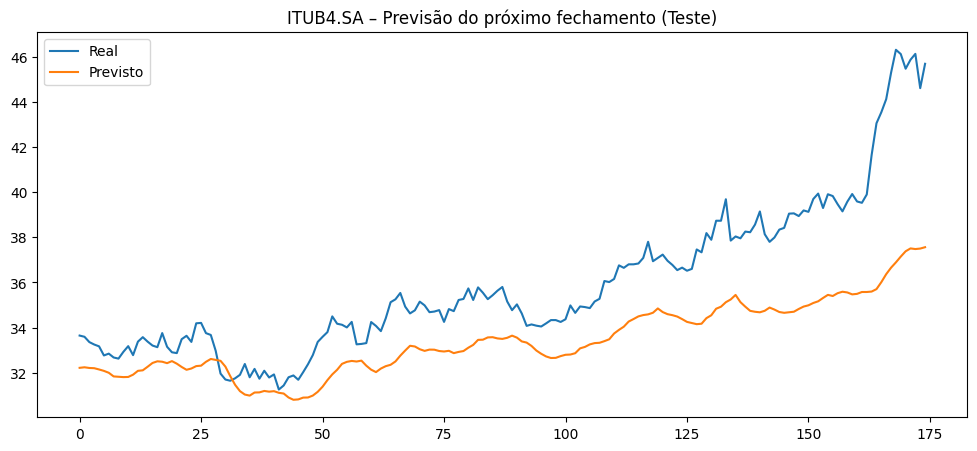

In [142]:
# 9) Gráfico Real vs Previsto (teste)
plt.figure(figsize=(12,5))
plt.plot(y_true, label="Real")
plt.plot(y_pred, label="Previsto")
plt.title("ITUB4.SA – Previsão do próximo fechamento (Teste)")
plt.legend()
plt.show()


In [143]:
# 10) Salvamento (modelo + scalers) para deploy em API
import os, json
import numpy as np

TICKER = "ITUB4.SA"

ARTIFACT_DIR = "artifacts_itub4"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

model_path = os.path.join(ARTIFACT_DIR, "best_model.keras")
model.save(model_path)

# Salvar scalers (min/scale) – suficiente para reconstruir MinMaxScaler na inferência
np.save(os.path.join(ARTIFACT_DIR, "x_scaler_min.npy"), x_scaler.min_)
np.save(os.path.join(ARTIFACT_DIR, "x_scaler_scale.npy"), x_scaler.scale_)

np.save(os.path.join(ARTIFACT_DIR, "y_scaler_min.npy"), y_scaler.min_)
np.save(os.path.join(ARTIFACT_DIR, "y_scaler_scale.npy"), y_scaler.scale_)

metrics = {
    "ticker": TICKER,
    "lookback": int(LOOKBACK),
    "features": list(FEATURE_COLS),
    "MAE": float(mae(y_true, y_pred)),
    "RMSE": float(rmse(y_true, y_pred)),
    "MAPE_pct": float(mape(y_true, y_pred)),
}

with open(os.path.join(ARTIFACT_DIR, "metrics.json"), "w", encoding="utf-8") as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)

print("Salvo em:", ARTIFACT_DIR)
print(metrics)


Salvo em: artifacts_itub4
{'ticker': 'ITUB4.SA', 'lookback': 10, 'features': ['Adj Close', 'Volume', 'simple_returns', 'std_last_5_returns', 'std_last_20_returns', 'avg_last_9', 'avg_last_21', 'rsi'], 'MAE': 2.482542037963867, 'RMSE': 3.1127028465270996, 'MAPE_pct': 6.544838905334473}


In [131]:
print("y_scaler min/max:", y_scaler.data_min_, y_scaler.data_max_)
print("yte scaled min/max:", yte.min(), yte.max())
print("y_pred_s min/max:", y_pred_s.min(), y_pred_s.max())
print("shapes:", yte.shape, y_pred_s.shape)


y_scaler min/max: [13.914319] [27.792536]
yte scaled min/max: 1.2493057 2.3351102
y_pred_s min/max: 1.1590028 1.5482423
shapes: (175, 1) (175, 1)
